Демьянчук Г.В. ИУ5-22М Л/Р №5

# Цель лабораторной работы
Изучить линейные модели, SVM и деревья решений<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите одну из&nbsp;линейных моделей, SVM и дерево решений. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра с&nbsp;использованием `GridSearchCV` и кросс-валидации.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [0]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [0]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используется оценка качества белых вин по шкале с учетом химических мер каждого вина:

In [0]:
data = pd.read_csv("/content/whitew.csv")

Проверим полученные типы:

In [4]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df = data.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Проверим размер набора данных:

In [8]:
df.shape

(1599, 12)

Проверим основные статистические характеристики набора данных:

In [9]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Проверим наличие пропусков в&nbsp;данных:

In [10]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
X = df.drop("density", axis=1)
y = df["density"]

In [12]:
print(X.head(), "\n")
print(y.head())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 11 columns] 

0    0.9978
1    0.9968
2    0.9970
3    0.9980
4    0.9978
Name: density, dtype: float64


In [13]:
print(X.shape)
print(y.shape)

(1599, 11)
(1599,)


Предобработаем данные, чтобы методы работали лучше:

In [14]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
count,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03,1.599000e+03
mean,3.435512e-16,1.699704e-16,4.335355e-16,-1.905223e-16,4.838739e-16,1.432042e-16,1.289532e-16,3.002879e-15,7.639596e-16,9.437243e-16,-8.051373e-16
std,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00,1.000313e+00
min,-2.137045e+00,-2.278280e+00,-1.391472e+00,-1.162696e+00,-1.603945e+00,-1.422500e+00,-1.230584e+00,-3.700401e+00,-1.936507e+00,-1.898919e+00,-3.265165e+00
25%,-7.007187e-01,-7.699311e-01,-9.293181e-01,-4.532184e-01,-3.712290e-01,-8.487156e-01,-7.440403e-01,-6.551405e-01,-6.382196e-01,-8.663789e-01,-7.878226e-01
50%,-2.410944e-01,-4.368911e-02,-5.636026e-02,-2.403750e-01,-1.799455e-01,-1.793002e-01,-2.574968e-01,-7.212705e-03,-2.251281e-01,-2.093081e-01,4.508484e-01
75%,5.057952e-01,6.266881e-01,7.652471e-01,4.341614e-02,5.384542e-02,4.901152e-01,4.723184e-01,5.759223e-01,4.240158e-01,6.354971e-01,4.508484e-01
max,4.355149e+00,5.877976e+00,3.743574e+00,9.195681e+00,1.112703e+01,5.367284e+00,7.375154e+00,4.528282e+00,7.918677e+00,4.202453e+00,2.928190e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1199, 11)
(400, 11)
(1199,)
(400,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

Попробуем метод Lasso с&nbsp;гиперпараметром $\alpha=1$:

In [18]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим метрики построенной модели:

In [19]:
test_model(las_1)

mean_absolute_error: 0.0014602999999999988
median_absolute_error: 0.0011639032527104298
r2_score: -0.0004891762509915409


Видно, что данный метод без&nbsp;настройки гиперпараметров не справляется с задачей и сильно хуже, чем метод $K$ ближайших соседей.

### SVM

Попробуем метод NuSVR с&nbsp;гиперпараметром $\nu=0{,}5$:

In [20]:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [21]:
test_model(nusvr_05)

mean_absolute_error: 0.0006310052519759896
median_absolute_error: 0.0004098770770791793
r2_score: 0.7627761496166849


Внезапно SVM показал хорошие результаты по&nbsp; всем показателям.

### Дерево решений

Попробуем дерево решений с&nbsp;неограниченной глубиной дерева:

In [22]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим метрики построенной модели:

In [23]:
test_model(dt_none)

mean_absolute_error: 0.00058325591786965
median_absolute_error: 0.0003984999999999683
r2_score: 0.8074608236964143


Дерево решений показало прямо-таки очень хороший результат по&nbsp;сравнению с&nbsp;рассмотренными раньше методами. Оценим структуру получившегося дерева решений:

In [0]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [25]:
stat_tree(dt_none)

Всего узлов: 599
Листовых узлов: 300
Глубина дерева: 15
Минимальная глубина листьев дерева: 4
Средняя глубина листьев дерева: 9.67


## Подбор гиперпараметра $K$

### Линейная модель — Lasso

Введем список настраиваемых параметров:

In [26]:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

Запустим подбор параметра:

In [27]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

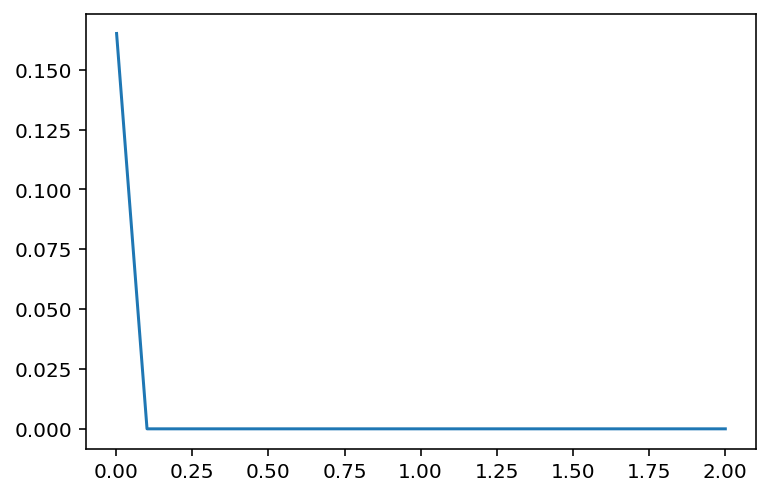

In [28]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод Lasso здесь не особо хорошо справляется, и здесь, скорее всего, было бы достаточно обычной линейной регрессии (в&nbsp;которую сходится Lasso при&nbsp;$\alpha=0$).

На&nbsp;тестовом наборе данных картина ровно та же:

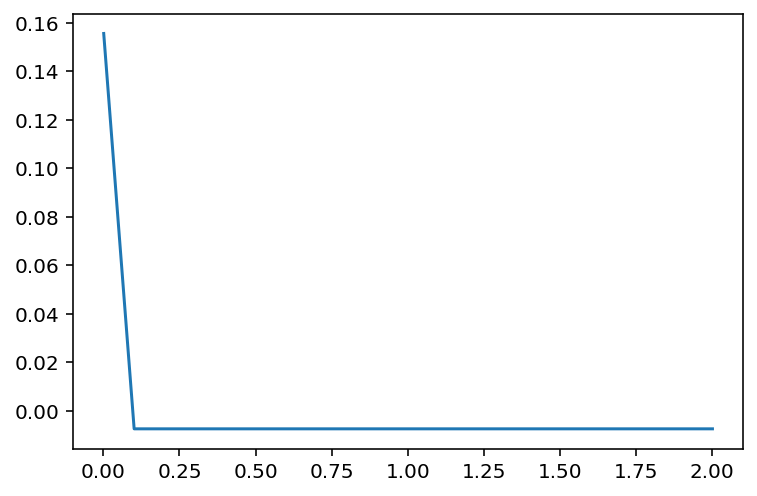

In [29]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Будем считать, что GridSearch показал, что нам нужна обычная линейная регрессия:

In [30]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.0005214481069142302
median_absolute_error: 0.0004026293294535077
r2_score: 0.870733752489801


В&nbsp;целом получили противоположный результат.

### SVM

Введем список настраиваемых параметров:

In [31]:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

Запустим подбор параметра:

In [32]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

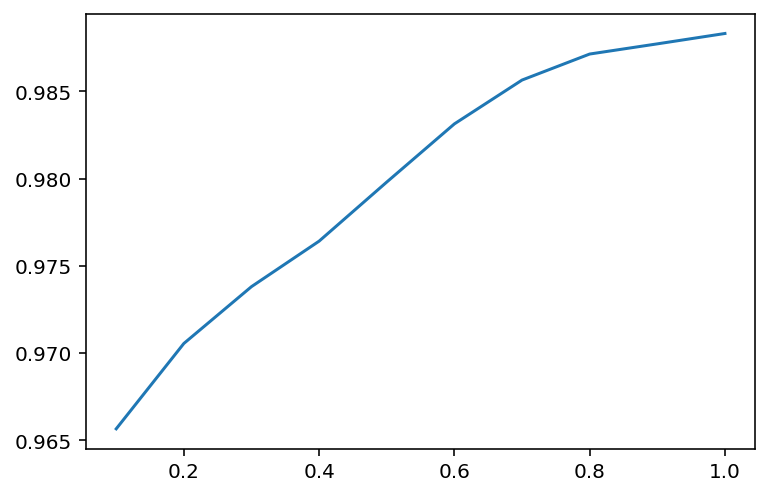

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше. При&nbsp;этом также видно, что разработчики библиотеки scikit-learn провели хорошую работу: получившееся оптимальное значение $\nu=0{,}1$ <cite data-cite="doc:sklearn"></cite>.

In [34]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.0005955515674434054
median_absolute_error: 0.00042228587287418407
r2_score: 0.8160658178733636


### Дерево решений

Введем список настраиваемых параметров:

In [35]:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

Запустим подбор параметра:

In [36]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

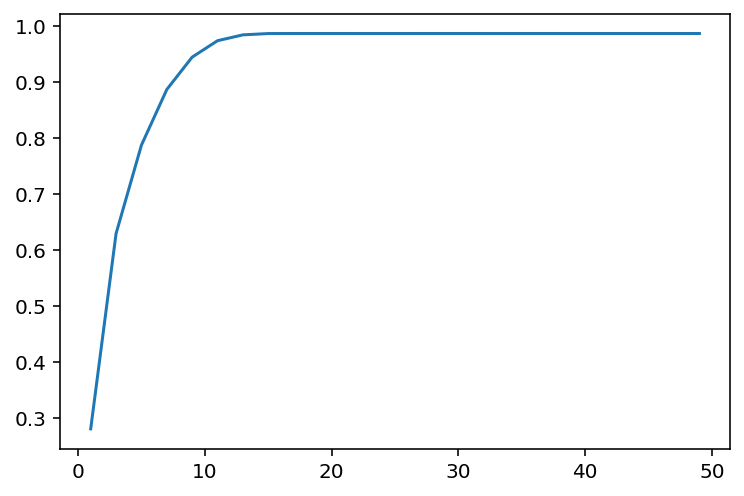

In [37]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что на&nbsp;тестовой выборке модель легко переобучается.

На&nbsp;тестовом наборе данных картина такая же:

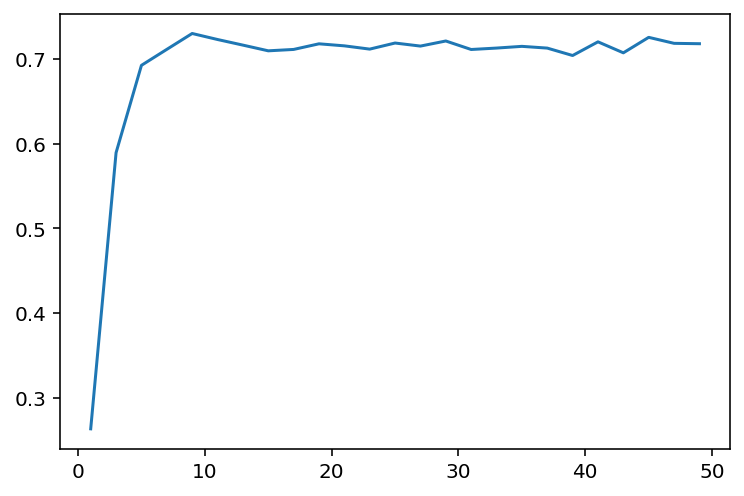

In [38]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [39]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.0006442837077933552
median_absolute_error: 0.0004721302308799413
r2_score: 0.7835805795644413


Посмотрим статистику получившегося дерева решений.

In [40]:
stat_tree(reg)

Всего узлов: 381
Листовых узлов: 191
Глубина дерева: 9
Минимальная глубина листьев дерева: 4
Средняя глубина листьев дерева: 8.089005235602095


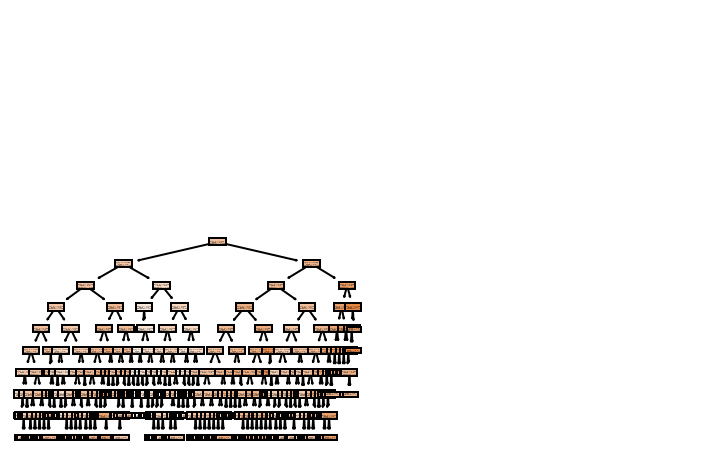

In [41]:
plot_tree(reg, filled=True);

Вывод функции `plot_tree` выглядит весьма странно. Видимо, для&nbsp;настолько больших деревьев решений она не&nbsp;предназначена. Возможно, это со&nbsp;временем будет исправлено, так как эту функциональность только недавно добавили.

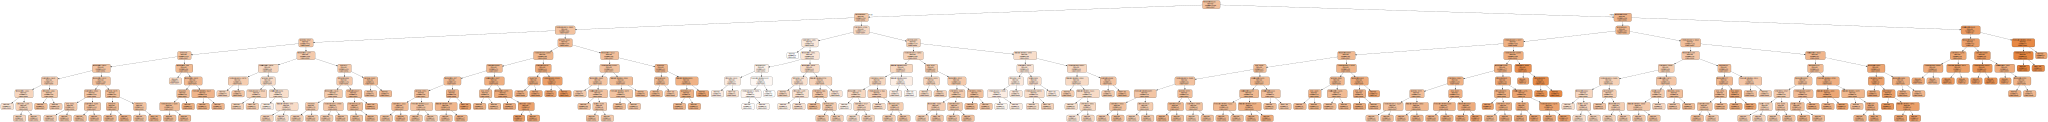

In [42]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Такое дерево уже можно анализировать. Видно, что сгенерировалось огромное множество различных условий, и, фактически, модель переобучена, но с&nbsp;другой стороны дерево решений и не&nbsp;могло быть построено иначе для&nbsp;задачи регрессии. К&nbsp;тому же на&nbsp;тестовой выборке данное дерево работает также довольно хорошо, так что, возможно, оно имеет право на&nbsp;существование. Если бы стояла задача классификации, то дерево решений явно показало бы себя просто отлично.